# LangGraph를 활용한 챗봇 구축

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## STEP1. 상태(State) 정의

In [2]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # 메시지 정의(list type 이며 add_messages 함수를 사용해 메시지를 추가)
    messages: Annotated[list, add_messages]

## STEP2. 노드(Node) 정의

In [11]:
from langchain_ollama import ChatOllama

# LLM 정의, Qwen2.5 7B
qwen = ChatOllama(model="qwen2.5:latest")

# 챗봇 함수 정의 
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [qwen.invoke(state["messages"])]}

## STEP3. 그래프(Graph)정의, 노드 추가

In [12]:
# 그래프 생성
graph_builder = StateGraph(State)

# 노드 이름, 함수 혹은 callable 객체를 인자로 받아 노드를 추가
graph_builder.add_node("chatbot", chatbot)

참고
- `chatbot` 노드 함수는 현재 `State`를 입력으로 받아 "messages"라는 키 아래에 업데이트된 messages 목록을 포함하는 사전(TypedDict) 을 반환합니다
- `State`의 `add_messages` 함수는 이미 상태에 있는 메시지에 llm의 응답 메시지를 추가합니다

## STEP4. 그래프 엣지(Edge) 추가
`START` 지점을 추가, `START`는 그래프가 실행될 때마다 작업을 시작할 위치 

In [13]:
# 시작 노드에서 챗봇 노드로의 엣지 추가
graph_builder.add_edge(START, "chatbot")

In [14]:
# 그래프에 엣지 추가
graph_builder.add_edge("chatbot", END)

## STEP5. 그래프 컴파일(compile)

In [15]:
# 그래프 컴파일
graph = graph_builder.compile()

## STEP6. 그래프 시각화

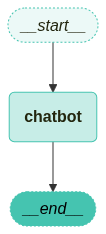

In [16]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

## STEP7. 그래프 실행

In [17]:
question = "서울의 유명한 맛집 TOP 10 추천해줘"

# 그래프 이벤트 스트리밍
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: 여기 서울에서 즐길 수 있는 다양한 카테고리의 유명 맛집 TOP 10을 추천해드리겠습니다:

1. 진로회인자 - 삼겹살 전문점, 경복궁 인근
2. 대박스시 - 김밥과 비빔밥으로 유명한 곳, 홍대 인근
3. 장이면 - 떡볶이와 순두부찌개 맛집, 양재동
4. 고기랑소주 - 갈비탕 전문점, 경복궁 인근
5. 이태원불닭발 - 불닭발 전문점, 이태원에 많음
6. 미호의 비빔밥 - 브라질 요리와 비빔밥을 즐길 수 있는 곳, 송파구
7. 월드비빔밥 - 다양한 나라의 비빔밥 맛집, 경복궁 인근
8. 칠순면장국 - 독특한 맛의 면장국 맛집, 양재동
9. 고기와소주 - 갈비탕과 소주를 즐길 수 있는 곳, 경복궁 인근
10. 뚝배기 - 대구에서 유래된 칠성미면 맛집, 강남역 인근

이 중에서 각자 선호하는 음식이나 위치에 따라 다른 선택을 하실 수 있습니다. 특히 대박스시와 미호의 비빔밥 같은 곳은 인기가 많아 예약을 하는 것이 좋습니다.
